In [8]:
from __future__ import annotations

import os
import sys
import math
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Notebook display defaults.
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 30)

# Project paths (kept consistent with the rest of the thesis notebooks).
PROJECT_ROOT = Path(r"C:\Users\bseis\ABthesis").resolve()
DATA_ROOT    = PROJECT_ROOT / "data"
PROCESSED    = DATA_ROOT / "processed"
ANALYSIS     = DATA_ROOT / "analysis"

# Weekly core + Top-1000 universe (training span).
CORE_DEFAULT    = PROCESSED / "crsp_weekly_core.parquet"
CORE_ALT_TRAIN  = PROCESSED / "crsp_weekly_core_1997-01-01_to_2018-06-29.parquet"
UNIV_TRAIN_FILE = PROCESSED / "crsp_weekly_universe_1997-01-01_to_2018-06-29_top1000_liq20p_rebalance-monthly_W-FRI.parquet"

# KSG / MI settings (match weekly_computation / robustness notebooks).
MI_MIN_OBS       = 156
KSG_K_BASE       = 6
KSG_N_SHUFFLES   = 20
KSG_SHUFFLE_SEED = 12345

WEEKS_PER_YEAR = 52

# Training window endpoints and candidate alternative start years.
TRAIN_START_FULL = pd.Timestamp("1997-01-03")
TRAIN_END        = pd.Timestamp("2018-06-29")

TRAIN_START_YEARS = [1997, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014]

# Output directory for the per-window MI/NMI artifacts.
MI_ROBUST_DIR = ANALYSIS / "mi_training_window_robustness"
MI_ROBUST_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT :", PROJECT_ROOT)
print("DATA_ROOT    :", DATA_ROOT)
print("PROCESSED    :", PROCESSED)
print("ANALYSIS     :", ANALYSIS)
print("MI_ROBUST_DIR:", MI_ROBUST_DIR)

WEEKLY_NOTEBOOK_DIR = PROJECT_ROOT / "notebooks" / "weekly"
if WEEKLY_NOTEBOOK_DIR.exists():
    sys.path.append(str(WEEKLY_NOTEBOOK_DIR))

# full KSG pipeline (returns NMI, H_bits, MI_raw)
from ksg_tools import redundancy_for_opt

PROJECT_ROOT : C:\Users\bseis\ABthesis
DATA_ROOT    : C:\Users\bseis\ABthesis\data
PROCESSED    : C:\Users\bseis\ABthesis\data\processed
ANALYSIS     : C:\Users\bseis\ABthesis\data\analysis
MI_ROBUST_DIR: C:\Users\bseis\ABthesis\data\analysis\mi_training_window_robustness


In [10]:
# elper functions for MI comparison and visualization

def upper_triangle_vector(df: pd.DataFrame, k: int = 1) -> np.ndarray:
    """
    Upper-triangular entries of a symmetric matrix as a 1D array.

    k=1 drops the diagonal (i<j). Non-finite entries are removed.
    """
    vals = df.to_numpy(dtype="float64")
    n = vals.shape[0]
    iu = np.triu_indices(n, k=k)
    v = vals[iu]
    mask = np.isfinite(v)
    return v[mask]

def mi_difference_metrics(M_base: pd.DataFrame, M_alt: pd.DataFrame) -> Dict[str, float]:
    """
    Compare two MI matrices on the same axis using off-diagonal entries only.

    Returns a small bundle of norms/summary stats so the comparison is easy to scan.
    """
    assert list(M_base.index) == list(M_base.columns)
    assert list(M_alt.index) == list(M_alt.columns)
    assert list(M_alt.index) == list(M_base.index)

    v_base = upper_triangle_vector(M_base, k=1)
    v_alt  = upper_triangle_vector(M_alt, k=1)

    m = np.isfinite(v_base) & np.isfinite(v_alt)
    v_base = v_base[m]
    v_alt  = v_alt[m]

    n_pairs = int(len(v_base))
    if n_pairs == 0:
        return dict(
            n_pairs=0,
            frob=np.nan,
            frob_rel=np.nan,
            corr=np.nan,
            mean_abs=np.nan,
            median_abs=np.nan,
            p90_abs=np.nan,
            p99_abs=np.nan,
        )

    diff = v_alt - v_base
    frob = float(np.linalg.norm(diff, ord=2))
    base_norm = float(np.linalg.norm(v_base, ord=2))
    frob_rel = float(frob / base_norm) if base_norm > 0 else np.nan
    corr = float(np.corrcoef(v_base, v_alt)[0, 1])

    abs_diff = np.abs(diff)
    mean_abs = float(abs_diff.mean())
    median_abs = float(np.median(abs_diff))
    p90_abs = float(np.quantile(abs_diff, 0.90))
    p99_abs = float(np.quantile(abs_diff, 0.99))

    return dict(
        n_pairs=n_pairs,
        frob=frob,
        frob_rel=frob_rel,
        corr=corr,
        mean_abs=mean_abs,
        median_abs=median_abs,
        p90_abs=p90_abs,
        p99_abs=p99_abs,
    )

def asset_row_correlations(M_base: pd.DataFrame, M_alt: pd.DataFrame) -> pd.Series:
    """
    Per-asset correlation between the corresponding rows of two MI matrices.

    The diagonal is ignored (self entry doesn't carry information for this comparison).
    """
    assert list(M_base.index) == list(M_base.columns)
    assert list(M_alt.index) == list(M_alt.columns)
    assets = list(M_base.index)

    vals_base = M_base.to_numpy(dtype="float64")
    vals_alt  = M_alt.to_numpy(dtype="float64")
    n = len(assets)
    corrs = []

    for i in range(n):
        row_base = vals_base[i, :]
        row_alt  = vals_alt[i, :]
        mask = np.isfinite(row_base) & np.isfinite(row_alt)
        mask[i] = False
        if mask.sum() < 2:
            corrs.append(np.nan)
        else:
            r = np.corrcoef(row_base[mask], row_alt[mask])[0, 1]
            corrs.append(float(r))

    return pd.Series(corrs, index=assets, name="row_corr")

def plot_difference_heatmap(
    M_base: pd.DataFrame,
    M_alt: pd.DataFrame,
    title: str,
    n_assets: int = 40,
    random_state: int = 0,
) -> None:
    """
    Heatmap of Δ = M_alt - M_base on a random subset of assets.
    """
    rng = np.random.default_rng(random_state)
    assets = list(M_base.index)

    if len(assets) <= n_assets:
        subset = assets
    else:
        subset = list(rng.choice(assets, size=n_assets, replace=False))

    B = M_base.loc[subset, subset]
    A = M_alt.loc[subset, subset]
    diff = A - B

    plt.figure(figsize=(6, 5))
    im = plt.imshow(diff.to_numpy(), aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(subset)), subset, rotation=90, fontsize=6)
    plt.yticks(range(len(subset)), subset, fontsize=6)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [12]:
# Load weekly TRAIN core and build simple-return panel for MI

print("Loading TRAIN universe and core panel…")

# Top-1000 training universe membership table.
assert UNIV_TRAIN_FILE.exists(), f"Missing {UNIV_TRAIN_FILE}"
u_train = pd.read_parquet(UNIV_TRAIN_FILE).copy()
u_train["date"]   = pd.to_datetime(u_train["date"], errors="coerce")
u_train["permno"] = pd.to_numeric(u_train["permno"], errors="coerce").astype("Int64")

# Training core panel (prefer the pre-sliced file when available).
core_path = CORE_ALT_TRAIN if CORE_ALT_TRAIN.exists() else CORE_DEFAULT
assert core_path.exists(), f"Missing core file at {core_path}"

core = pd.read_parquet(core_path).copy()
core["date"]   = pd.to_datetime(core["date"], errors="coerce")
core["permno"] = pd.to_numeric(core["permno"], errors="coerce").astype("Int64")
if "ticker" in core.columns:
    core["ticker"] = core["ticker"].astype(str).str.upper()

print("[core] using", core_path.name)
print("core date span:", core["date"].min(), "→", core["date"].max())

# Restrict to the training window and the as-of Top-1000 membership list (same convention as weekly_processing).
mask_train = (core["date"] >= TRAIN_START_FULL) & (core["date"] <= TRAIN_END)

uni_asof = u_train[u_train["date"] == TRAIN_END].copy()
if uni_asof.empty:
    last_date = u_train.loc[u_train["date"] <= TRAIN_END, "date"].max()
    uni_asof = u_train[u_train["date"] == last_date].copy()
uni_asof = uni_asof[uni_asof["in_universe"].fillna(False)]
permnos_asof = uni_asof["permno"].dropna().astype("Int64").unique().tolist()
print(f"[universe] as-of {TRAIN_END.date()}: {len(permnos_asof)} PERMNOs")

core_train = core[mask_train & core["permno"].isin(permnos_asof)].copy()
print("core_train rows:", core_train.shape[0])

# Simple returns column for MI estimation (mirrors the Experiment 3 setup).
if "ret_total" in core_train.columns:
    RET_COL = "ret_total"
else:
    RET_COL = "ret"
assert RET_COL in core_train.columns, f"Return column {RET_COL!r} not in core_train!"
print("Using RET_COL =", RET_COL)

# Wide simple-return panel (date × permno).
R_train_full = (
    core_train
    .pivot_table(index="date", columns="permno", values=RET_COL, aggfunc="last")
    .sort_index()
    .dropna(how="all")
)
print("R_train_full shape:", R_train_full.shape)

# Restrict to the as-of universe AND only permnos that actually appear in the wide panel.
assets_permnos = sorted(
    set(permnos_asof).intersection(set(R_train_full.columns.astype("Int64")))
)

R_TRAIN_MI_BASE = R_train_full.loc[:, assets_permnos].copy()

# Keep asset IDs as strings for consistency with the saved MI artifacts and later comparisons.
R_TRAIN_MI_BASE.columns = R_TRAIN_MI_BASE.columns.astype(str)
ASSETS_STATIC = list(R_TRAIN_MI_BASE.columns)

print("R_TRAIN_MI_BASE shape:", R_TRAIN_MI_BASE.shape)
print("TRAIN window (MI base):", R_TRAIN_MI_BASE.index.min().date(), "→", R_TRAIN_MI_BASE.index.max().date())
print("N_assets:", len(ASSETS_STATIC))

Loading TRAIN universe and core panel…
[core] using crsp_weekly_core_1997-01-01_to_2018-06-29.parquet
core date span: 1996-12-27 00:00:00 → 2018-06-29 00:00:00
[universe] as‑of 2018-06-29: 1000 PERMNOs
core_train rows: 1065748
Using RET_COL = ret_total
R_train_full shape: (1122, 1000)
R_TRAIN_MI_BASE shape: (1122, 1000)
TRAIN window (MI base): 1997-01-03 → 2018-06-29
N_assets: 1000


In [14]:
# Build training-window grid aligned to weekly dates

# Use the existing weekly index so every window start lands on an actual observation date.
train_dates = R_TRAIN_MI_BASE.index.sort_values().unique()

train_start_dates: List[pd.Timestamp] = []
for y in TRAIN_START_YEARS:
    candidate = pd.Timestamp(f"{y}-01-01")

    # Pick the first available weekly date on/after Jan 1 of that year.
    valid_dates = train_dates[train_dates >= candidate]
    if len(valid_dates) == 0:
        continue
    t0 = valid_dates[0]
    train_start_dates.append(t0)

train_start_dates = sorted(set(train_start_dates))

print("Training start dates (aligned to weekly grid):")
for t0 in train_start_dates:
    mask = (R_TRAIN_MI_BASE.index >= t0) & (R_TRAIN_MI_BASE.index <= TRAIN_END)
    n_weeks = int(mask.sum())
    print(f"  {t0.date()}  → {TRAIN_END.date()}  ({n_weeks} weeks)")


Training start dates (aligned to weekly grid):
  1997-01-03  → 2018-06-29  (1122 weeks)
  2000-01-07  → 2018-06-29  (965 weeks)
  2002-01-04  → 2018-06-29  (861 weeks)
  2004-01-02  → 2018-06-29  (757 weeks)
  2006-01-06  → 2018-06-29  (652 weeks)
  2008-01-04  → 2018-06-29  (548 weeks)
  2010-01-01  → 2018-06-29  (444 weeks)
  2012-01-06  → 2018-06-29  (339 weeks)
  2014-01-03  → 2018-06-29  (235 weeks)


In [16]:
# Estimate MI / NMI for each training window (full KSG pipeline, no PSD / no ridge)

# Store results in memory keyed by the training start date.
mi_mats: Dict[pd.Timestamp, pd.DataFrame] = {}
nmi_mats: Dict[pd.Timestamp, pd.DataFrame] = {}
entropy_vecs: Dict[pd.Timestamp, pd.Series] = {}

for t0 in train_start_dates:
    print("\n" + "=" * 80)
    print(f"[MI window] {t0.date()} → {TRAIN_END.date()}")
    print("=" * 80)

    # Slice the simple-return panel down to this training window.
    R_window = R_TRAIN_MI_BASE.loc[
        (R_TRAIN_MI_BASE.index >= t0) & (R_TRAIN_MI_BASE.index <= TRAIN_END),
        :
    ]
    print("  R_window shape:", R_window.shape)

    # Run the exact KSG pipeline used elsewhere. At this stage we want the raw MI/NMI outputs
    # before any PSD projection or ridge (those happen later in the Q build).
    NMI_opt_k, H_bits_k, MI_raw_k = redundancy_for_opt(
        df=R_window,
        start=None,
        end=None,
        use_log_returns=False,
        returns_are_log=False,
        standardize=True,
        min_obs=MI_MIN_OBS,
        k=KSG_K_BASE,
        normalize="sqrt",
        clamp_negative=False,
        shrink_eps=0.0,
        shuffle_debias=True,
        ns_shuffles=KSG_N_SHUFFLES,
        shuffle_seed=KSG_SHUFFLE_SEED,
        debias_only_if_leq=1e-6,
    )

    # Keep a consistent asset axis (string permnos) so comparisons are straightforward.
    assets = ASSETS_STATIC
    R_mi = MI_raw_k.reindex(index=assets, columns=assets)
    R_nmi = NMI_opt_k.reindex(index=assets, columns=assets)

    # Enforce symmetry explicitly; diagonals are handled by the upstream pipeline settings.
    R_mi = 0.5 * (R_mi + R_mi.T)
    R_nmi = 0.5 * (R_nmi + R_nmi.T)

    mi_mats[t0] = R_mi
    nmi_mats[t0] = R_nmi
    entropy_vecs[t0] = H_bits_k.reindex(index=assets)

    # Persist artifacts so later notebooks can reuse them without re-running KSG.
    tag = t0.strftime("%Y%m%d")
    mi_path = MI_ROBUST_DIR / f"mi_bits_trainstart_{tag}_k{KSG_K_BASE}_min{MI_MIN_OBS}_sqrt.parquet"
    nmi_path = MI_ROBUST_DIR / f"nmi_bits_trainstart_{tag}_k{KSG_K_BASE}_min{MI_MIN_OBS}_sqrt.parquet"
    H_path   = MI_ROBUST_DIR / f"entropy_bits_trainstart_{tag}_k{KSG_K_BASE}_min{MI_MIN_OBS}_sqrt.parquet"

    R_mi.to_parquet(mi_path)
    R_nmi.to_parquet(nmi_path)
    entropy_vecs[t0].to_frame("H_bits").to_parquet(H_path)

    print("  Saved MI  to:", mi_path.name)
    print("  Saved NMI to:", nmi_path.name)
    print("  Saved H   to:", H_path.name)


[MI window] 1997-01-03 → 2018-06-29
  R_window shape: (1122, 1000)
  Saved MI  to: mi_bits_trainstart_19970103_k6_min156_sqrt.parquet
  Saved NMI to: nmi_bits_trainstart_19970103_k6_min156_sqrt.parquet
  Saved H   to: entropy_bits_trainstart_19970103_k6_min156_sqrt.parquet

[MI window] 2000-01-07 → 2018-06-29
  R_window shape: (965, 1000)
  Saved MI  to: mi_bits_trainstart_20000107_k6_min156_sqrt.parquet
  Saved NMI to: nmi_bits_trainstart_20000107_k6_min156_sqrt.parquet
  Saved H   to: entropy_bits_trainstart_20000107_k6_min156_sqrt.parquet

[MI window] 2002-01-04 → 2018-06-29
  R_window shape: (861, 1000)
  Saved MI  to: mi_bits_trainstart_20020104_k6_min156_sqrt.parquet
  Saved NMI to: nmi_bits_trainstart_20020104_k6_min156_sqrt.parquet
  Saved H   to: entropy_bits_trainstart_20020104_k6_min156_sqrt.parquet

[MI window] 2004-01-02 → 2018-06-29
  R_window shape: (757, 1000)
  Saved MI  to: mi_bits_trainstart_20040102_k6_min156_sqrt.parquet
  Saved NMI to: nmi_bits_trainstart_2004010

In [17]:
# How different are MI estimates vs baseline window?

# Use the earliest window (1997 start) as the baseline for comparisons.
t_base = min(train_start_dates)
M_base = mi_mats[t_base]

print("Baseline window:", t_base.date(), "→", TRAIN_END.date())
print("Baseline MI shape:", M_base.shape)

rows_metrics: List[dict] = []
asset_corr_frames: List[pd.Series] = []

for t0 in train_start_dates:
    M_alt = mi_mats[t0]

    # Track how much data each window is using (weeks in the input panel).
    mask = (R_TRAIN_MI_BASE.index >= t0) & (R_TRAIN_MI_BASE.index <= TRAIN_END)
    n_weeks = int(mask.sum())

    metrics = mi_difference_metrics(M_base, M_alt)
    metrics.update(
        train_start=t0,
        n_assets=M_alt.shape[0],
        n_weeks=n_weeks,
    )
    rows_metrics.append(metrics)

    # Row-wise correlations highlight which assets have stable dependence structure vs baseline.
    row_corr = asset_row_correlations(M_base, M_alt)
    row_corr.name = t0
    asset_corr_frames.append(row_corr)

df_metrics = (
    pd.DataFrame(rows_metrics)
    .set_index("train_start")
    .sort_index()
)

df_asset_corrs = pd.concat(asset_corr_frames, axis=1)

print("\n=== Global MI-difference metrics (off-diagonal entries) ===")
display(df_metrics)

print("\n=== Per-asset row-wise MI stability vs baseline (summary stats) ===")
display(df_asset_corrs.describe(percentiles=[0.10, 0.25, 0.50, 0.75, 0.90]))

Baseline window: 1997-01-03 → 2018-06-29
Baseline MI shape: (1000, 1000)

=== Global MI‑difference metrics (off‑diagonal entries) ===


,n_pairs,frob,frob_rel,corr,mean_abs,median_abs,p90_abs,p99_abs,n_assets,n_weeks
train_start,,,,,,,,,,
1997-01-03,452676,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1000,1122
2000-01-07,452676,14.125261,0.135149,0.982207,0.012019,0.004354,0.035874,0.075430,1000,965
2002-01-04,452676,24.766550,0.236964,0.954434,0.022338,0.010355,0.062675,0.127179,1000,861
2004-01-02,452676,34.647600,0.331504,0.923275,0.031602,0.014871,0.087960,0.175105,1000,757
2006-01-06,452676,45.049996,0.431033,0.894146,0.041478,0.019827,0.114751,0.226183,1000,652
2008-01-04,452676,57.292441,0.548168,0.865891,0.054193,0.027936,0.146452,0.281128,1000,548
2010-01-01,452676,54.356201,0.520074,0.839054,0.052777,0.031976,0.132276,0.275624,1000,444
2012-01-06,452676,50.206031,0.480366,0.797628,0.050945,0.035894,0.116061,0.238302,1000,339
2014-01-03,452676,60.649290,0.580286,0.744097,0.061884,0.045001,0.136283,0.287995,1000,235



=== Per‑asset row‑wise MI stability vs baseline (summary stats) ===


,1997-01-03,2000-01-07,2002-01-04,2004-01-02,2006-01-06,2008-01-04,2010-01-01,2012-01-06,2014-01-03
count,9.520000e+02,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000,952.000000
mean,1.000000e+00,0.974883,0.941301,0.905572,0.873591,0.841639,0.796510,0.734778,0.662676
std,8.443088e-17,0.022370,0.045248,0.070320,0.092097,0.109210,0.118005,0.137169,0.158765
min,1.000000e+00,0.889233,0.778498,0.652582,0.568655,0.505225,0.450606,0.358151,0.225895
10%,1.000000e+00,0.943361,0.875707,0.808614,0.749587,0.691383,0.628739,0.553072,0.448093
25%,1.000000e+00,0.960677,0.911673,0.855966,0.808999,0.764634,0.714364,0.629386,0.542780
50%,1.000000e+00,0.978108,0.945669,0.911136,0.880139,0.850260,0.805593,0.737166,0.660746
75%,1.000000e+00,0.996169,0.983188,0.972064,0.964117,0.941010,0.895470,0.849179,0.786251
90%,1.000000e+00,0.998724,0.993844,0.990357,0.987054,0.979504,0.946083,0.916214,0.874987
max,1.000000e+00,0.999774,0.998875,0.998246,0.997202,0.996844,0.993023,0.989943,0.989052


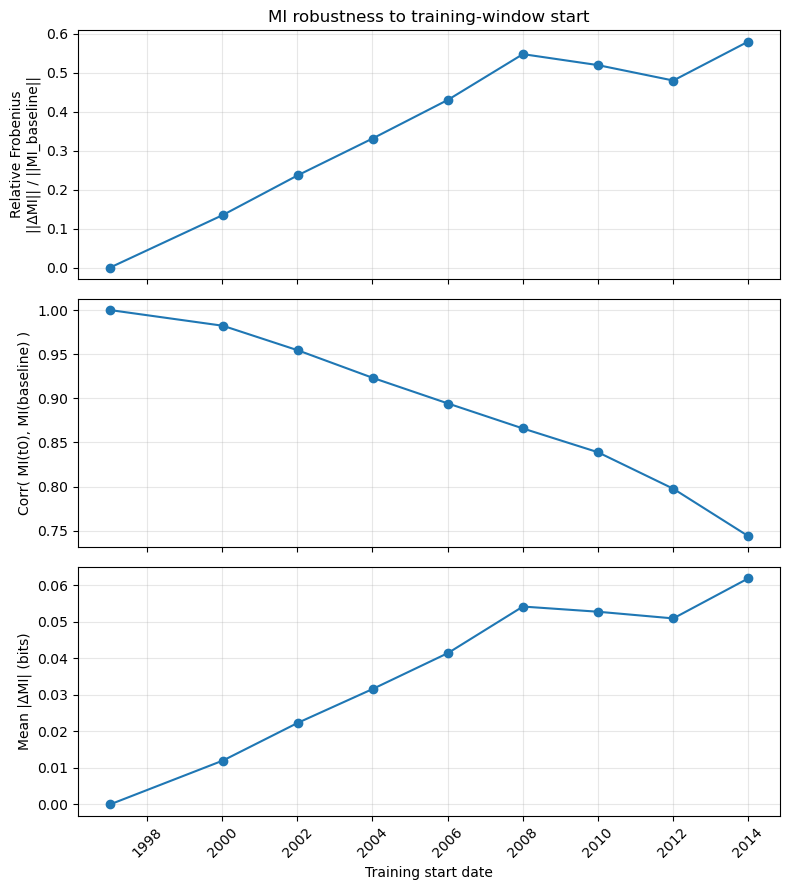

In [18]:
# MI sensitivity to the training-window start

fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

# Relative Frobenius norm: scale-free measure of how far MI(t0) is from MI(baseline).
axes[0].plot(df_metrics.index, df_metrics["frob_rel"], marker="o")
axes[0].set_ylabel("Relative Frobenius\n||ΔMI|| / ||MI_baseline||")
axes[0].set_title("MI robustness to training-window start")

# Correlation of off-diagonal entries: structural similarity to the baseline MI.
axes[1].plot(df_metrics.index, df_metrics["corr"], marker="o")
axes[1].set_ylabel("Corr( MI(t0), MI(baseline) )")

# Mean absolute difference: typical magnitude of pairwise MI changes (in bits).
axes[2].plot(df_metrics.index, df_metrics["mean_abs"], marker="o")
axes[2].set_ylabel("Mean |ΔMI| (bits)")
axes[2].set_xlabel("Training start date")

# Light grid for readability.
for ax in axes:
    ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

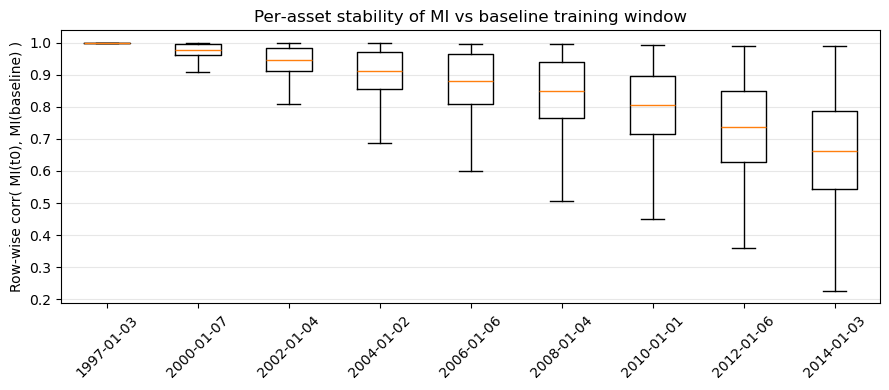

In [19]:
plt.figure(figsize=(9, 4))

positions = np.arange(len(train_start_dates))
data = [df_asset_corrs[col].dropna().to_numpy() for col in df_asset_corrs.columns]
labels = [d.date().isoformat() for d in df_asset_corrs.columns]

plt.boxplot(data, positions=positions, showfliers=False)
plt.xticks(positions, labels, rotation=45)
plt.ylabel("Row-wise corr( MI(t0), MI(baseline) )")
plt.title("Per-asset stability of MI vs baseline training window")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

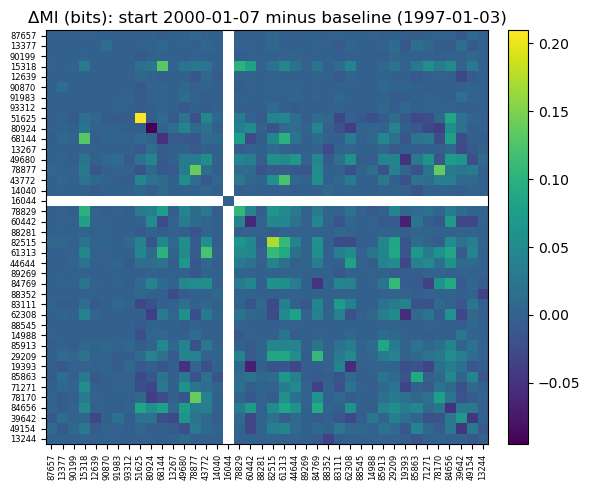

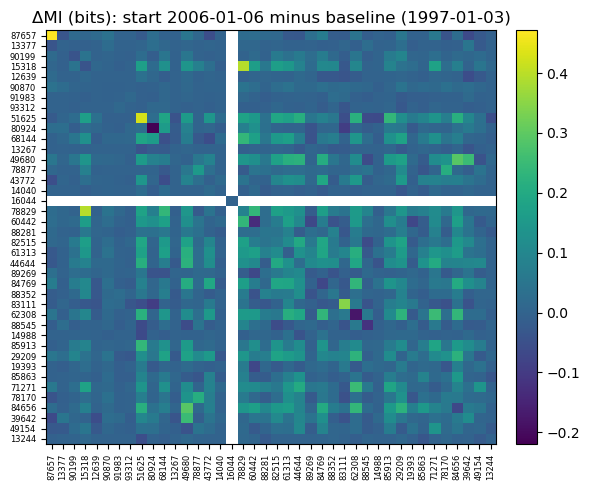

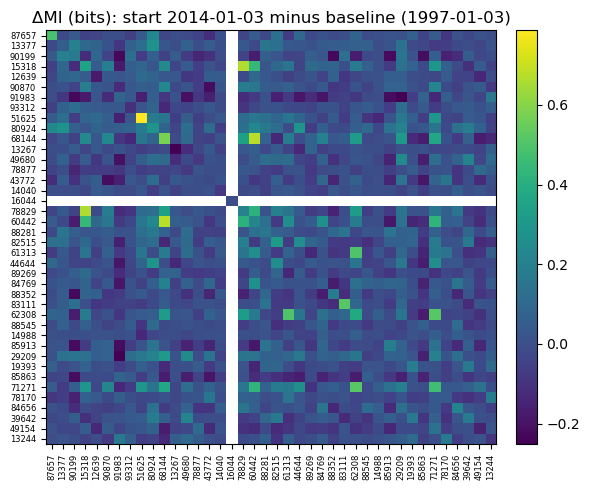

In [20]:
representatives: List[pd.Timestamp] = []

# Earliest non-baseline start.
if len(train_start_dates) > 1:
    representatives.append(train_start_dates[1])

# A midpoint start in the grid.
representatives.append(train_start_dates[len(train_start_dates) // 2])

# Latest start (avoid duplicates if already selected).
if train_start_dates[-1] not in representatives:
    representatives.append(train_start_dates[-1])

# Plot ΔMI = MI(t0) − MI(baseline) on a random subset of assets for each case.
for t0 in representatives:
    M_alt = mi_mats[t0]
    title = f"ΔMI (bits): start {t0.date()} minus baseline (1997-01-03)"
    plot_difference_heatmap(M_base, M_alt, title=title, n_assets=40, random_state=42)